In [1]:
# Import modules
import json
import pandas as pd
import plotly.express as px
from jupyter_dash import JupyterDash
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

In [2]:
# Import geo data
districts_cph = json.load(open("data/geodata-districts-cph.json", "r", encoding='utf-8'))

In [3]:
# Create dictionary with district name and id
districts_id_map = {}
for feature in districts_cph["features"]:
    districts_id_map[feature["properties"]["navn"]] = feature["id"]

In [4]:
# Import income data
df_income = pd.read_csv('data/avg-income-districts-cph.csv', encoding = "ISO-8859-1", sep=';')

In [5]:
# Clean district rows
df_income['district'] = df_income['district'].str[11:]

In [6]:
# Change district name 
df_income['district'].replace({"Vesterbro/Kongens Enghave": "Vesterbro-Kongens Enghave"}, inplace=True)

In [7]:
# Pivot data from wide to long format
df_income_long = (df_income.melt(id_vars = 'district', 
                                 var_name = 'year', 
                                 value_name = 'avg_income')) # https://towardsdatascience.com/reshape-pandas-dataframe-with-melt-in-python-tutorial-and-visualization-29ec1450bb02

In [8]:
# Create 'id' column
df_income_long["id"] = df_income_long["district"].apply(lambda x: districts_id_map[x])

In [9]:
df_income_2019 = df_income_long[df_income_long['year'] == '2019']

In [10]:
# Define values and text for the color bar
max_value_colorbar = round(df_income_2019['avg_income'].max(), -4)
min_value_colorbar = round(df_income_2019['avg_income'].min(), -4)

colorbar_values = list(range(min_value_colorbar, max_value_colorbar, 40000))

colorbar_text = list(map('{:,d}'.format, colorbar_values))

# Change the thousand separator to a dot
colorbar_text_dot = []

for string in colorbar_text:
    new_string = string.replace(",", ".")
    colorbar_text_dot.append(new_string)

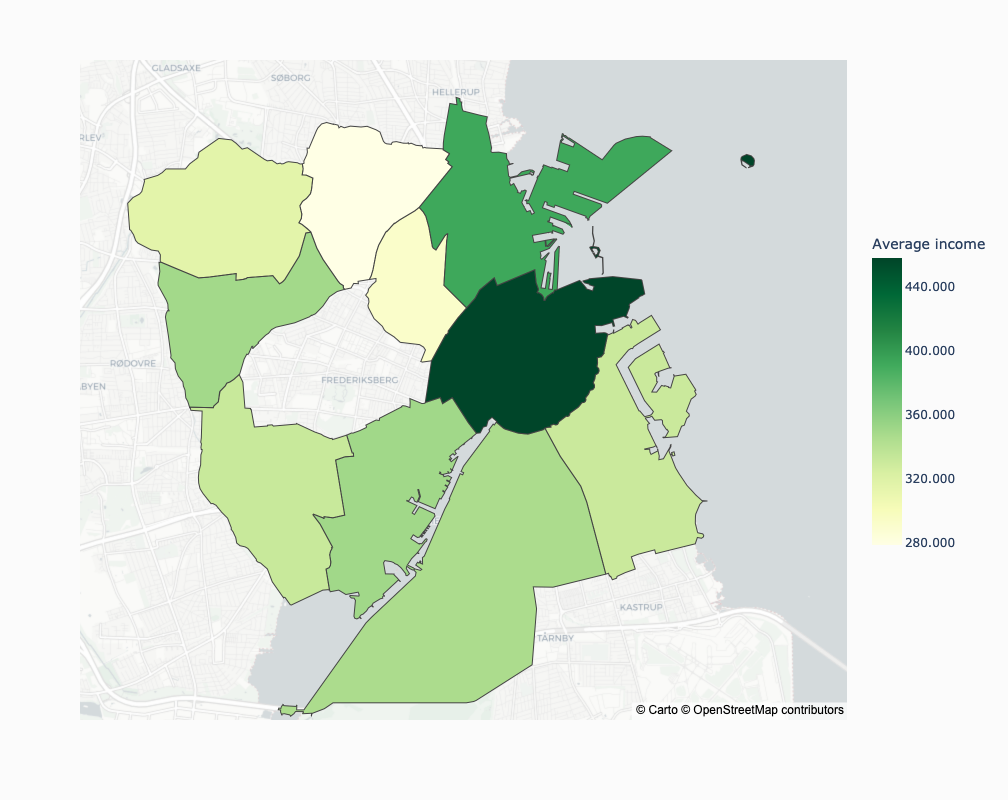

In [25]:

fig = px.choropleth_mapbox(
    df_income_2019,
    locations="id",
    geojson=districts_cph,
    color="avg_income",
    color_continuous_scale="YlGn",
    mapbox_style="carto-positron",
    center={"lat": 55.6760968, "lon": 12.5683371},
    zoom=11,
    width=1200,
    height=800,
    labels={'avg_income':'Average income'},
    custom_data=["district", "year", "avg_income"]
)

fig.update_layout(
    dragmode=False,
    paper_bgcolor="#fbfbfb",
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family='Arial'
    ),
    separators=",.",
    coloraxis_colorbar=dict(
        title='Average income',
        tickvals=colorbar_values,
        ticktext=colorbar_text_dot,
        len=0.5
    )
)

fig.update_traces(
  hovertemplate=("</br><b>%{customdata[0]}</b></br>" +
                "Year: %{customdata[1]}</br>" +
                "Avg. income: %{customdata[2]:,.d} dkr."))



In [26]:
# Create app

app = JupyterDash(__name__)

app.layout = html.Div(children=[
    
    html.H1("Change in the average income in the districts of Copenhagen"),
    
    dcc.Graph(
        id='example-graph',
        figure=fig,
        config={
        'displayModeBar': False
    }
  )
])


# Run app and display result inline in the notebook
app.run_server(mode='external')

Dash app running on http://127.0.0.1:8050/
